In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.context("plotly_white")
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import pickle
from datetime import datetime, timedelta
from scipy.signal import find_peaks
from statsmodels.stats.multitest import multipletests

import statsmodels.api as sm
from sklearn.metrics import r2_score
import warnings
import gc
from copy import deepcopy

In [2]:
df = pd.read_csv("data/us_data.csv")
all_states = pd.unique(df['state'])
all_states = all_states[(all_states != 'District of Columbia')]
df = df[df['state'].isin(all_states)]
df['date'] = pd.to_datetime(df['date'])

us_state_abbrev = pickle.load(open("data/us_state_abbrev.pkl", "rb"))
state_codes = pickle.load(open("data/state_codes.pkl", "rb"))

In [3]:
def learn_betas(curr_state, start_time, end_time, R0=2.5, df=df):
    with warnings.catch_warnings():
        curr_df = df[df['state'] == curr_state]
        curr_df = curr_df[['date', 'daily_cases', 'daily_deaths']]
        case_df = curr_df.set_index('date').resample('W-Mon').sum()
        case_df = case_df.rename(columns={"daily_cases": "weekly_cases", "daily_deaths": 'weekly_deaths'})
        case_df = case_df.iloc[:-2]

        new_df = pd.DataFrame(index=case_df.index)
        new_df['X1(t)'] = np.log(case_df['weekly_cases'] + 1)
        new_df['X1(t-1)'] = new_df['X1(t)'].shift(1).fillna(0)
        new_df['X2(t-1)'] = new_df['X1(t)'] - new_df['X1(t-1)'] - np.log(R0)
        new_df['X2(t-2)'] = new_df['X2(t-1)'].shift(1).fillna(0)


        state_coefs_dict = {}

        X = new_df[['X1(t-1)', 'X2(t-2)']]
        X = sm.add_constant(X)
        X_train = X.iloc[start_time:end_time]

        y = new_df['X1(t)'] - new_df['X1(t-1)'] - new_df['X2(t-2)'] - np.log(R0)
        y_train = y.iloc[start_time:end_time]


        model = sm.OLS(y_train,X_train)
        results = model.fit()
        
        beta1 = results.params['X1(t-1)']
        beta2 = results.params['X2(t-2)']
        constant = results.params['const']
        return beta1, beta2, constant, results

In [4]:
def predict(curr_state, beta1, beta2, const, R0=2.5, df=df):
    curr_df = df[df['state'] == curr_state]
    curr_df = curr_df[['date', 'daily_cases', 'daily_deaths']]
    case_df = curr_df.set_index('date').resample('W-Mon').sum()
    case_df = case_df.rename(columns={"daily_cases": "weekly_cases", "daily_deaths": 'weekly_deaths'})
    case_df = case_df.iloc[:-2]
    
    new_df = pd.DataFrame(index=case_df.index)
    new_df['X1(t)'] = np.log(case_df['weekly_cases'] + 1)
    new_df['X1(t-1)'] = new_df['X1(t)'].shift(1).fillna(0)
    new_df['X2(t-1)'] = new_df['X1(t)'] - new_df['X1(t-1)'] - np.log(R0)
    new_df['X2(t-2)'] = new_df['X2(t-1)'].shift(1).fillna(0)
    
    full_preds = beta1*new_df['X1(t-1)'] + beta2*new_df['X2(t-2)'] + const + \
                new_df['X1(t-1)'] + new_df['X2(t-2)'] + np.log(R0)
    return np.exp(full_preds) - 1, np.exp(new_df['X1(t)']) - 1

In [5]:
learned_betas = []
for curr_state in all_states:   
    with warnings.catch_warnings():
        #  0-26
        start_time = 0
        end_time = 26
        beta1, beta2, const, results = learn_betas(curr_state, start_time, end_time)
        full_preds, actual = predict(curr_state, beta1, beta2, const)

        ## compute r2 scores
        r2_in = r2_score(full_preds.iloc[start_time:end_time], actual.iloc[start_time:end_time])
        r2_pre = np.nan #r2_score(full_preds.iloc[:start_time], actual.iloc[:start_time])
        if(end_time is not None):
            r2_post = r2_score(full_preds.iloc[end_time:], actual.iloc[end_time:])
        else:
            r2_post = np.nan
        learned_betas.append({
            'state': curr_state,
            'state_fips': state_codes[us_state_abbrev[curr_state]],
            'peak_no': '0to26',
            'start_time': start_time,
            'end_time': end_time,
            'beta1': beta1,
            'beta2':beta2,
            'const': const,
            'r2_in': r2_in,
            'r2_pre': r2_pre,
            'r2_post': r2_post
        })

betas_df = pd.DataFrame(learned_betas)

## Comparison to Auxiliary Data

In [6]:
# SafeGraph -- not publically available
# d1 = datetime.strptime("2020-01-01", "%Y-%m-%d")
# d2 = datetime.strptime("2021-04-16", "%Y-%m-%d")
# all_dates = [datetime.strftime(d1 + timedelta(days=x), "%Y-%m-%d") for x in range((d2-d1).days + 1)]

# all_dfs = []
# for curr_date in all_dates:
#     curr_df = pd.read_csv(f'DayMobilities/state_mobility_{curr_date}.csv', 
#                           index_col=0,
#                          dtype={'state_fips': str})
#     all_dfs.append(curr_df)

# full_df = pd.concat(all_dfs)
# full_df['date'] = pd.to_datetime(full_df['date'])
# safegraph_df = full_df

# gc.collect()
# del all_dfs
# del full_df
# safegraph_df = safegraph_df[[i for i in safegraph_df.columns if not i.startswith("median")]]


# safegraph_df['mean_distance_traveled_from_home'] = np.log(safegraph_df['mean_distance_traveled_from_home'] + 1).fillna(0)

In [7]:
# Google
google_df = pd.read_csv("data/US_combined_mobility.csv")
google_df['date'] = pd.to_datetime(google_df['date'])

google_df = google_df[~google_df['sub_region_1'].isnull() & (google_df['sub_region_2'].isnull())]
google_df['state_fips'] = google_df['sub_region_1'].map(us_state_abbrev).map(state_codes)

print([i for i in google_df.columns if i.endswith("from_baseline")])

# google_df = google_df.groupby("state_fips").apply(lambda x: x.set_index("date")\
#                                                    .resample("W-Mon").mean()).reset_index()

google_df = google_df[['state_fips', 'date'] + \
                      [i for i in google_df.columns if i.endswith("from_baseline")]].dropna()

from sklearn.decomposition import PCA
g_bs = google_df[[i for i in google_df.columns if i.endswith("from_baseline")]]

pca = PCA(n_components=2)
pca.fit(g_bs)
print(pca.explained_variance_ratio_)

transformed = pca.fit_transform(g_bs)
for i in range(2):
    google_df[f'pc{i+1}_google'] = transformed[:, i]
    
google_df = google_df[['state_fips', 'date']  + [i for i in google_df.columns if i.startswith("pc")]].dropna()

['retail_and_recreation_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline', 'parks_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline', 'workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline']
[0.87996469 0.08839923]


In [8]:
pca.components_

array([[ 0.12311746,  0.09981855,  0.96873962,  0.18246876,  0.04305729,
        -0.03568067],
       [-0.42607198, -0.24579683,  0.23868034, -0.72190218, -0.39546231,
         0.15344406]])

In [9]:
# Vaccinations
vaccine_df = pd.read_csv("data/us_state_vaccinations.csv")
cols = [
        'people_fully_vaccinated_per_hundred', 
        #'total_vaccinations_per_hundred'
       ]
agg_vaccine_df = vaccine_df[['date', 'location'] + cols].groupby('location').mean()
agg_vaccine_df['state_fips'] = agg_vaccine_df.index.map(us_state_abbrev).map(state_codes)
agg_vaccine_df = agg_vaccine_df.dropna()

In [10]:
## Cumulative cases
cum_case_df = df.groupby(["state"]).apply(lambda x: x[['date', 'daily_cases', 'daily_deaths']].set_index("date").resample('W-Mon').sum().cumsum())
cum_case_df = cum_case_df.reset_index().rename(columns=
                                               {'daily_cases': 'cumulative_cases', 
                                                'daily_deaths': 'cumulative_deaths'})
cum_case_df['state_fips'] = cum_case_df['state'].map(us_state_abbrev).map(state_codes)

pops = pd.read_excel("data/populations.xlsx", index_col=0)
pops = pops[[2019]].reset_index().dropna()
pops.columns = ['state', 'population']
pops['state'] = pops['state'].str.replace(".","")

case_pop_df = pd.merge(cum_case_df, pops, on='state', how='left').dropna()
case_pop_df['cumulative_cases_normalized'] = case_pop_df['cumulative_cases'] / case_pop_df['population']
case_pop_df.head()

,state,date,cumulative_cases,cumulative_deaths,state_fips,population,cumulative_cases_normalized
0,Alabama,2020-01-27,0.0,0.0,01,4903185.0,0.0
1,Alabama,2020-02-03,0.0,0.0,01,4903185.0,0.0
2,Alabama,2020-02-10,0.0,0.0,01,4903185.0,0.0
3,Alabama,2020-02-17,0.0,0.0,01,4903185.0,0.0
4,Alabama,2020-02-24,0.0,0.0,01,4903185.0,0.0


In [11]:
## Mask Policy Indicator
mask_policy_df = pd.read_csv("data/mask_mandate_data.csv")
mask_policy_df['date'] = pd.to_datetime(mask_policy_df['date'])
mask_policy_df['state_fips'] = mask_policy_df['state'].map(us_state_abbrev).map(state_codes)

In [12]:
mask_policy_df = mask_policy_df.dropna()

## Coefficient Comparison

In [13]:
coef_p_arr = []

mask_policy_col_pairs = [("Mask Policy", mask_policy_df, "mask_mandate") ]
vac_col_pairs =  [("Vaccines", agg_vaccine_df, i) for i in agg_vaccine_df.columns if i != "state_fips"]
# safegraph_col_pairs = [("Safegraph", safegraph_df, i) for i in safegraph_df.columns if i.startswith("mean")]
google_col_pairs = [("Google", google_df, i) for i in google_df.columns if i.startswith("pc")]
case_col_pairs = [("Cases", case_pop_df, i) for i in case_pop_df.columns if i.startswith("cumulative_cases_")]

df_col_pairs = google_col_pairs +  case_col_pairs + mask_policy_col_pairs + \
        vac_col_pairs # + safegraph_col_pairs

def time_from_idx(idx):
    if(pd.isnull(idx)):
        return datetime.strptime("2023-01-01", "%Y-%m-%d")
    else:
        return datetime.strptime("2020-01-27", "%Y-%m-%d") + timedelta(weeks=(idx))
        
all_peak_nos = ["0to26"]
for peak_no in all_peak_nos:
    curr_df = deepcopy(betas_df[betas_df['peak_no'] == peak_no].reset_index(drop=True))
    print(peak_no, [x[2] for x in df_col_pairs])
    for (lbl, aux_df, x_col) in df_col_pairs:
        if((lbl == "Masks") or (lbl == "Vaccines")):
            try:
                if(x_col not in curr_df.columns):
                    curr_df = pd.merge(curr_df, aux_df[['state_fips', x_col]], on='state_fips')
                X = deepcopy(curr_df[[x_col]])
                X = sm.add_constant(X)
            except Exception as e:
                print(curr_df)
                print(e)
                break
        elif((lbl == "Safegraph") or (lbl == "Google")):
            curr_df[x_col] = 0
            for i, row in curr_df.iterrows():
                end_time = row['end_time'] if (row['end_time'] is not np.nan) else 1000
                small_aux_df = aux_df[(aux_df['state_fips'] == row['state_fips']) &
                                      (aux_df['date'] <= time_from_idx(end_time) - timedelta(days=1)) &
                                      (aux_df['date'] >= time_from_idx(row['start_time']))]
                curr_df.iloc[i, curr_df.columns.get_loc(x_col)] = small_aux_df[x_col].mean()
            X = deepcopy(curr_df[[x_col]])
            X = sm.add_constant(X)
        elif((lbl == "Cases")):
            curr_df[x_col] = 0
            for i, row in curr_df.iterrows():
                small_aux_df = aux_df[(aux_df['state_fips'] == row['state_fips']) &
                                      (aux_df['date'] <= time_from_idx(end_time) - timedelta(days=1)) &
                                      (aux_df['date'] >= time_from_idx(row['start_time']))]
                curr_df.iloc[i, curr_df.columns.get_loc(x_col)] = small_aux_df[x_col].max()
            X = deepcopy(curr_df[[x_col]])
            X = sm.add_constant(X)
        elif (lbl == "Mask Policy"):
            curr_df[x_col] = 0
            for i, row in curr_df.iterrows():
                small_aux_df = aux_df[(aux_df['state_fips'] == row['state_fips']) &
                                      (aux_df['date'] <= time_from_idx(end_time) - timedelta(days=1)) &
                                      (aux_df['date'] >= time_from_idx(row['start_time']))]
                curr_df.iloc[i, curr_df.columns.get_loc(x_col)] = small_aux_df[x_col].mean()
            X = deepcopy(curr_df[[x_col]])
            X = sm.add_constant(X)
        #curr_df = curr_df.drop(columns=[x_col])
        
        for y_col in ['beta1', 'beta2']:
            y = curr_df[y_col]

            model = sm.OLS(y, X)
            results = model.fit()
            coef_p_arr.append({
                'dep': y_col,
                'ind': x_col,
                'peak_no': peak_no,
                'coef': results.params[x_col],
                'offset': results.params['const'],
                'pval_coef': results.pvalues[x_col],
#                 'pval_offset': results.pvalues['const'],
#                 'r2': results.rsquared,
#                 'r2_adj': results.rsquared_adj
            })

0to26 ['pc1_google', 'pc2_google', 'cumulative_cases_normalized', 'mask_mandate', 'people_fully_vaccinated_per_hundred']


In [14]:
pvalue_df = pd.DataFrame(coef_p_arr)
sorted_df = pvalue_df.sort_values(by='pval_coef')

alpha = 0.1
sorted_df['reject_0'] = multipletests(sorted_df['pval_coef'], alpha=alpha, method='fdr_bh')[0]
sorted_df

,dep,ind,peak_no,coef,offset,pval_coef,reject_0
8,beta1,people_fully_vaccinated_per_hundred,0to26,-0.003829,0.018516,0.000147,True
2,beta1,pc2_google,0to26,-0.000471,-0.043294,0.003798,True
1,beta2,pc1_google,0to26,-0.001027,-0.499272,0.055591,False
9,beta2,people_fully_vaccinated_per_hundred,0to26,-0.019189,-0.179096,0.072984,False
6,beta1,mask_mandate,0to26,-0.017093,-0.039460,0.079247,False
5,beta2,cumulative_cases_normalized,0to26,7.116153,-0.574183,0.127913,False
3,beta2,pc2_google,0to26,0.002164,-0.517901,0.184052,False
4,beta1,cumulative_cases_normalized,0to26,0.608479,-0.052491,0.209778,False
7,beta2,mask_mandate,0to26,-0.057099,-0.480119,0.550130,False
0,beta1,pc1_google,0to26,-0.000003,-0.046431,0.962373,False


In [15]:
latex_df = sorted_df.copy()[['dep', 'ind', 'coef', 'pval_coef', 'reject_0']]
latex_df['dep'] = sorted_df['dep'].map({
    'beta1': '$\\beta_1$',
    'beta2': '$\\beta_2$'
})

latex_df['reject_0'] = sorted_df['reject_0'].map({
    True: '$\\checkmark$',
    False: ''
})

latex_df['pval_coef'] = sorted_df['pval_coef'].apply(lambda x: round(x, 3))
latex_df['coef'] = sorted_df['coef'].apply(lambda x: round(x, 3))

latex_df['ind'] = sorted_df['ind'].map({
    "people_fully_vaccinated_per_hundred": 'Vaccination Rate (\\%)',
    "pc1_google": 'Mobility Component 1',
    "pc2_google": 'Mobility Component 2',
    "mean_distance_traveled_from_home": "Mean Distance Traveled From Home",
    "mean_median_percentage_time_home": "Median Percentage Time Home",
    "cumulative_cases_normalized": "Natural Immunity (\\%)",
    "mask_mandate": "Mask Mandate",
    "mean_median_non_home_dwell_time": "Median Time Spent Away From Home"
})

latex_df = latex_df.rename(columns = {
    'dep': 'Dependent Variable',
    'ind': 'Independent Variable',
    'coef': "Coefficient Value",
    'pval_coef': "$p$-value",
    "reject_0": "\\shortstack{Null Hypothesis\\\\ Rejected}"
})

In [16]:
print(latex_df.to_latex(index=False, escape=False))

\begin{tabular}{llrrl}
\toprule
Dependent Variable &   Independent Variable &  Coefficient Value &  $p$-value & \shortstack{Null Hypothesis\\ Rejected} \\
\midrule
         $\beta_1$ &  Vaccination Rate (\%) &             -0.004 &      0.000 &                            $\checkmark$ \\
         $\beta_1$ &   Mobility Component 2 &             -0.000 &      0.004 &                            $\checkmark$ \\
         $\beta_2$ &   Mobility Component 1 &             -0.001 &      0.056 &                                         \\
         $\beta_2$ &  Vaccination Rate (\%) &             -0.019 &      0.073 &                                         \\
         $\beta_1$ &           Mask Mandate &             -0.017 &      0.079 &                                         \\
         $\beta_2$ &  Natural Immunity (\%) &              7.116 &      0.128 &                                         \\
         $\beta_2$ &   Mobility Component 2 &              0.002 &      0.184 &                   

## Figure 13

(array([-0.11, -0.1 , -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03,
        -0.02]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

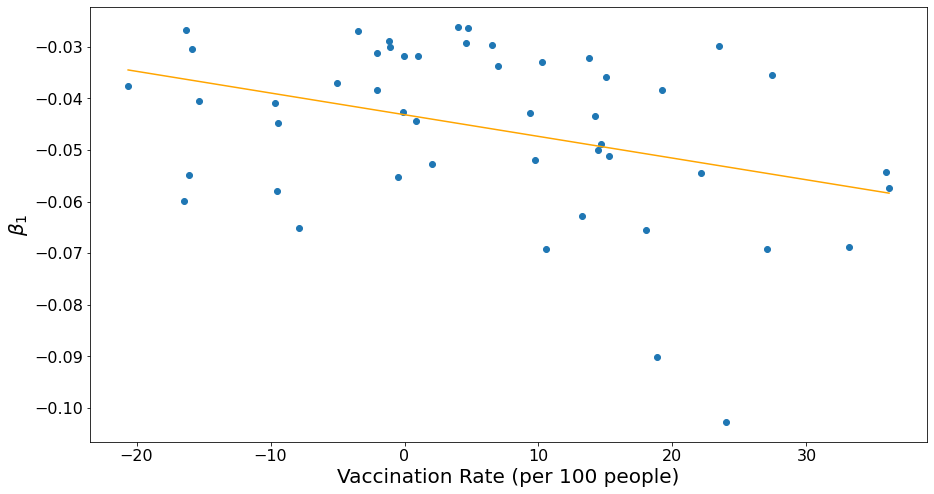

In [17]:
x_col = 'pc2_google'

X = curr_df[[x_col]]
X = sm.add_constant(X)
y = curr_df[['beta1']]

model = sm.OLS(y, X)
results = model.fit()

plt.figure(figsize=(15, 8))
plt.scatter(X[x_col],y)

X_plot = np.linspace(X[x_col].min(), X[x_col].max(),100)
plt.plot(X_plot, X_plot * results.params[1] + results.params[0], color='orange')
plt.xlabel("Vaccination Rate (per 100 people)", fontsize=20)
plt.ylabel("$\\beta_1$", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

#plt.savefig("parameter_comparison.png", dpi=300)